In [1]:
import pandas as pd

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd

### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
### 제목

In [2]:
# 1. Shapefile 불러오기 (NRT와 Archive 파일)
shapefile_path_archive = "./USA data/DL_FIRE_SV-C2_590018/fire_archive_SV-C2_590018.shp"
shapefile_path_nrt = "./USA data/DL_FIRE_SV-C2_590018/fire_nrt_SV-C2_590018.shp"

# 각각 Shapefile 읽기
gdf_archive = gpd.read_file(shapefile_path_archive)
gdf_nrt = gpd.read_file(shapefile_path_nrt)

# 2. 두 Shapefile 병합 (pandas concat 사용)
gdf = pd.concat([gdf_archive, gdf_nrt], ignore_index=True)

# 3. GeoDataFrame CRS 일치 (기본적으로 같을 가능성이 높지만, 확인 후 일치시킴)
gdf = gdf.to_crs(epsg=4326)  # WGS 84 좌표계로 변환

# 4. 이미 처리된 cleaned_wildfire_df 불러오기
# cleaned_wildfire_df는 이미 위도, 경도, 그리고 필요한 정보가 있는 데이터라고 가정
cleaned_wildfire_df = pd.read_csv("./USA data/cleaned_wildfire.csv")

# 5. cleaned_wildfire_df를 GeoDataFrame으로 변환
# cleaned_wildfire_df에서 좌표 정보 (latitude, longitude)로 Point 객체 생성
geometry = [Point(lon, lat) for lon, lat in zip(cleaned_wildfire_df['longitude'], cleaned_wildfire_df['latitude'])]
geo_df = gpd.GeoDataFrame(cleaned_wildfire_df, geometry=geometry)

# 6. GeoDataFrame의 좌표계를 맞추기 (Shapefile과 일치)
geo_df = geo_df.set_crs(gdf.crs, allow_override=True)

# 7. 병합: 두 GeoDataFrame을 'geometry' 컬럼 기준으로 병합
merged_gdf = gdf.merge(geo_df, on='geometry', how='inner')

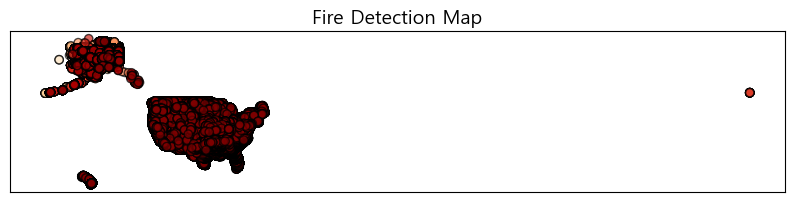

In [3]:
# 8. 시각화 (GeoPandas 사용)
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, cmap='OrRd', edgecolor='black', alpha=0.7)

# 제목 추가
ax.set_title("Fire Detection Map", fontsize=14)

# 축 제거 (지도만 보이게)
ax.set_xticks([])
ax.set_yticks([])

# 시각화 실행
plt.show()

In [4]:
# 샘플링된 GeoDataFrame 생성
merged_gdf_sample = merged_gdf.sample(frac=0.1)  # 10% 샘플링

# 1. Timestamp 형식을 문자열로 변환 (ACQ_DATE 예시)
merged_gdf_sample['ACQ_DATE'] = merged_gdf_sample['ACQ_DATE'].dt.strftime('%Y-%m-%d %H:%M:%S')

# 지도 중심 설정 (예: [37.5, -120] 캘리포니아)
m = folium.Map(location=[37.5, -120], zoom_start=6)

# MarkerCluster 생성
marker_cluster = MarkerCluster().add_to(m)

# GeoDataFrame을 GeoJSON 형식으로 변환하여 성능 개선
geojson_data = merged_gdf_sample.to_json()

In [ ]:
# GeoJSON 데이터를 지도에 추가 (시각화)
folium.GeoJson(
    geojson_data,
    name="Fire Detection",
    popup=folium.Popup(fields=['FRP', 'ACQ_DATE'], parse_html=True)
).add_to(marker_cluster)

# 지도 저장
m.save("fire_map_geojson.html")
print("Map saved as fire_map_geojson.html")


In [7]:
# 7. 폴리곤 주변에 버퍼 생성 (500m 반경)
gdf['geometry'] = gdf['geometry'].buffer(0.005)  # 0.005도 ≈ 500m

# 8. 면적 계산 (제곱미터 단위, 좌표계 변환 필요)
gdf = gdf.to_crs(epsg=32610)  # UTM으로 변환 (정확한 면적 계산용)
gdf['area_m2'] = gdf.geometry.area

# 전체 면적 계산
total_area_m2 = gdf['area_m2'].sum()
total_area_km2 = total_area_m2 / 1e6  # 제곱킬로미터로 변환
print(f"Total Predicted Area (Buffer): {total_area_km2:.2f} km²")

# 9. FRP 가중치 적용
gdf['weighted_area'] = gdf['FRP'] * gdf['area_m2'] / gdf['FRP'].mean()
total_weighted_area_km2 = gdf['weighted_area'].sum() / 1e6
print(f"FRP-Weighted Predicted Area: {total_weighted_area_km2:.2f} km²")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_164\3091555634.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(0.005)  # 0.005도 ≈ 500m


Total Predicted Area (Buffer): 4598491.38 km²
FRP-Weighted Predicted Area: 4406106.99 km²
